In [46]:
import keras
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
import sklearn
from sklearn import preprocessing, model_selection
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import string
from string import *
import pymongo
from collections import Counter

In [2]:
mc = pymongo.MongoClient()
db = mc['allrecipes']
recipes_coll = db['recipes']
results_coll = db['search_results']

In [3]:
cursor = recipes_coll.find()
chili_recipes = []
recipe_ids = []
for recipe in cursor:
    if recipe['category']['lvl_2'] == 'Chili':
        chili_recipes.append(recipe)
        recipe_ids.append(recipe['id'])

In [4]:
ingredients = Counter()
for recipe in chili_recipes:
    for item in recipe['ingredients']:
        ingredients[item['ingredient']] += 1
print('Number of unique ingredients :', len(ingredients))

Number of unique ingredients : 364


In [5]:
common_ingredients = []
for item, count in ingredients.most_common():
    if count > 1:
        common_ingredients.append(item)
print('Number of common ingredients :', len(common_ingredients))

Number of common ingredients : 165


In [7]:
chili_df = pd.DataFrame(columns=common_ingredients, index=recipe_ids).fillna(0)
for recipe in chili_recipes:
    idx = recipe['id']
    servings = recipe['directions']['servings']
    for item in recipe['ingredients']: 
        ing = item['ingredient']
        qty = item['normalized_qty']
        if ing in chili_df.columns:
            chili_df.loc[idx, ing] = qty / servings if servings else qty
chili_df

,onion,chili powder,cumin,tomato,garlic,beef,salt,oregano,kidney beans,green bell pepper,...,dry red wine,vinegar,dark brown sugar,red pepper,canola oil,beef stew meat,italianstyle tomato,lemon juice,beef chuck,chipotle chile powder
214843,2.000000,0.083333,0.020833,3.333333,0.083333,3.333333,0.041667,0.000000,0.000000,1.333333,...,0.00,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000,0.000000,0.000000
26462,2.000000,0.125000,0.020833,0.000000,0.000000,4.000000,0.000000,0.000000,1.875000,0.750000,...,0.00,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000,0.000000,0.000000
15386,1.142857,0.178571,0.000000,0.000000,0.000000,2.285714,0.047619,0.000000,2.142857,0.000000,...,0.00,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000,0.000000,0.000000
16188,2.000000,0.125000,0.000000,1.208333,0.416667,4.000000,0.000000,0.000000,3.750000,0.000000,...,0.00,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000,0.000000,0.000000
8835,1.600000,0.100000,0.033333,2.900000,0.200000,0.000000,0.008333,0.033333,3.800000,1.200000,...,0.00,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000,0.000000,0.000000
13067,0.000000,0.166667,0.027778,0.000000,0.000000,2.666667,0.000000,0.000000,0.000000,0.000000,...,0.00,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000,0.000000,0.000000
24406,1.333333,0.000000,0.000000,1.666667,0.000000,5.333333,0.000000,0.000000,0.000000,0.000000,...,0.00,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000,0.000000,0.000000
23118,1.333333,0.166667,0.000000,0.000000,0.083333,4.000000,0.000000,0.013889,2.500000,0.000000,...,0.00,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000,0.000000,0.000000
15868,1.333333,0.166667,0.083333,2.666667,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000,0.000000,0.000000
80760,1.333333,0.416667,0.055556,0.000000,0.250000,6.666667,0.000000,0.055556,2.500000,1.000000,...,0.00,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000,0.000000,0.000000


In [151]:
model = Sequential()
model.add(Dense(100,  activation='relu', input_shape=(165,)))
model.add(Dense(20,  activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(10,  activation='relu'))
model.add(Dense(2,    activation='linear', name="bottleneck"))
model.add(Dense(10,  activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(20,  activation='relu'))
model.add(Dense(100,  activation='relu'))
model.add(Dense(165,  activation='linear'))
model.compile(loss='mean_squared_error', optimizer = 'adam')

In [9]:
X = chili_df.values

In [12]:
means = np.mean(chili_df, axis=0)
stds = np.std(chili_df, axis=0)

In [18]:
chili_scaled = (chili_df - means) / stds

In [19]:
X_scaled = chili_scaled.values

In [155]:
history = model.fit(X_scaled, X_scaled, batch_size=60, epochs=1000, verbose=None)

In [44]:
encoder = Model(model.input, model.get_layer('bottleneck').output)
z_enc = encoder.predict(X_scaled)  # bottleneck representation
r_enc = model.predict(X_scaled)        # reconstruction

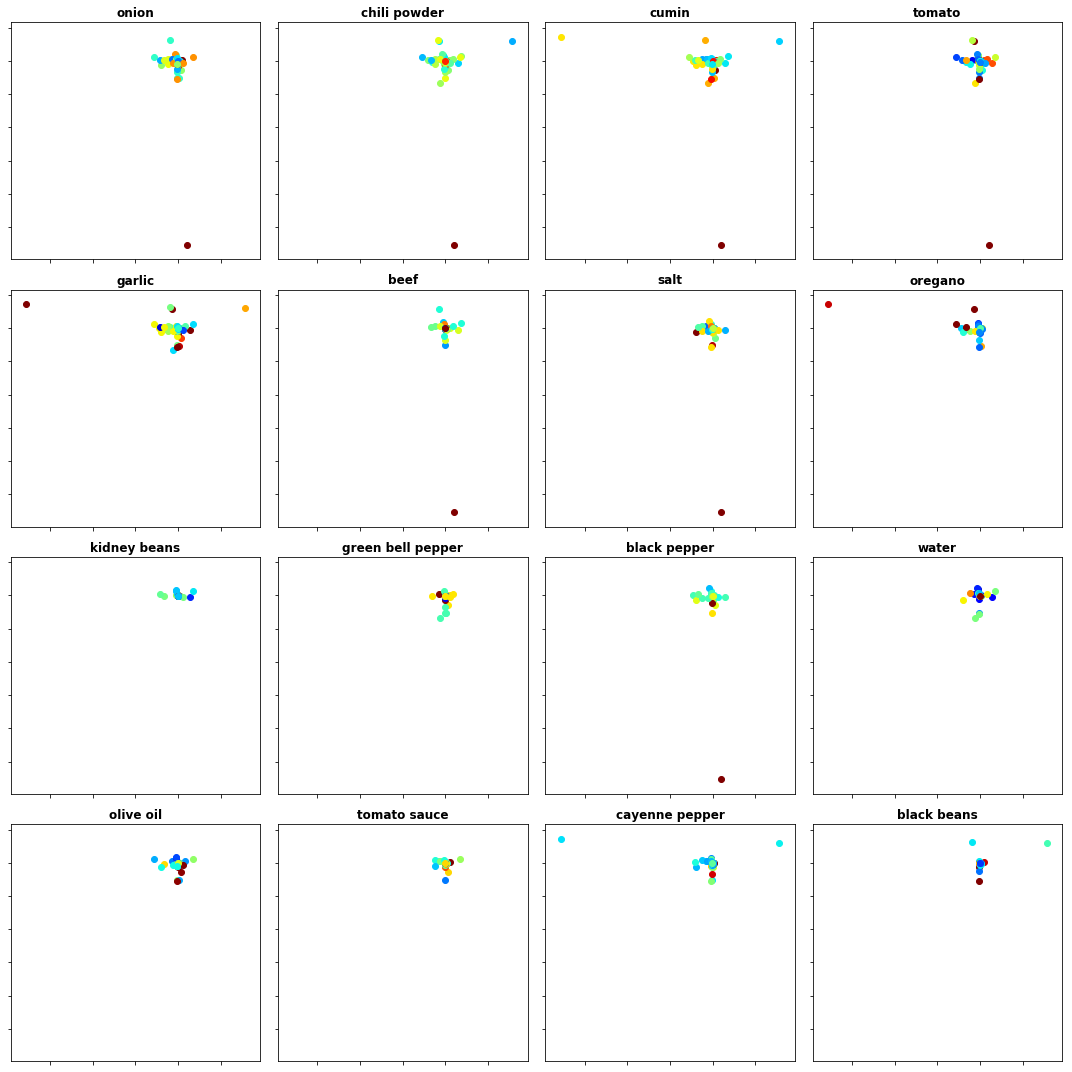

In [153]:
encoder = Model(model.input, model.get_layer('bottleneck').output)
z_enc = encoder.predict(X_scaled)  # bottleneck representation

fig, axs = plt.subplots(4, 4,figsize=(15, 15), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
    ing = chili_df.columns[i]
    alpha= (chili_df[ing] != 0).astype(float).values
    mean_ing = np.mean(chili_df[chili_df[ing]!=0][ing])
    std_ing = np.std(chili_df[chili_df[ing]!=0][ing])
    color = [cm.jet((val-(mean_ing)) / (3*std_ing) + 0.5) for val in chili_df[ing]]
    for j in range(len(z_enc)):
        z0 = z_enc[j, 0]
        z1 = z_enc[j, 1]
        ax.scatter(z0, z1, color=color[j], alpha=alpha[j])
    ax.set_title(ing, fontweight='bold')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
fig.tight_layout()

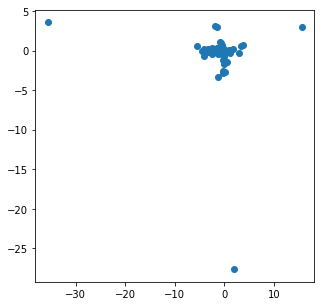

In [154]:
encoder = Model(model.input, model.get_layer('bottleneck').output)
z_enc = encoder.predict(X_scaled)

fig, ax = plt.subplots(figsize=(5, 5))
z0 = z_enc[:, 0]
z1 = z_enc[:, 1]
ax.scatter(z0, z1)

In [122]:
cm.jet(200)

(1.0, 0.46550472040668145, 0.0, 1.0)

In [142]:
cm.jet()

(0.9456327985739753, 0.029774872912127992, 0.0, 1.0)

In [145]:
ing = 'beef'
mean_ing = np.mean(chili_df[chili_df[ing]!=0][ing])
std_ing = np.std(chili_df[chili_df[ing]!=0][ing])
color = [(val-(mean_ing)) / (3*std_ing) + 0.5 for val in chili_df[ing]]
print('Max color :', max(color))
print('Min color :', min(color))

Max color : 2.6071414878357806
Min color : -0.055845748546449414


In [138]:
color = [cm.jet(25 * (val-(mean_ing)) / std_ing + 75) for val in chili_df[ing]]

In [139]:
color

[(0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0, 0.0, 1.0),
 (0.5, 0.0,